# Time Series

In [94]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#plt.style.use('seaborn-darkgrid')
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.tsaplots import acf,pacf

In [95]:
data = pd.read_csv('timeseries.csv')

In [96]:
import pandas as pd

# Convert 'Report_Date' column to datetime if it's not already
data['Report_Date'] = pd.to_datetime(data['Report_Date'])


# Group by 'Report_Date' and count the occurrences
timeseries = data.groupby(pd.Grouper(key='Report_Date', freq='D')).size().reset_index(name='Count')

# Set 'Report_Date' column as the index
timeseries.set_index('Report_Date', inplace=True)

#Change Count column to numeric type
timeseries['Count'] = pd.to_numeric(timeseries['Count'])

In [97]:
timeseries.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2921 entries, 2016-02-13 to 2024-02-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   2921 non-null   int64
dtypes: int64(1)
memory usage: 45.6 KB


In [98]:
timeseries.head()

,Count
Report_Date,
2016-02-13,49
2016-02-14,56
2016-02-15,51
2016-02-16,84
2016-02-17,91


In [99]:
timeseries.sort_values(by=['Count'], ascending=False)


,Count
Report_Date,
2023-02-07,209
2020-06-01,180
2019-10-12,160
2016-10-31,152
2016-10-24,146
...,...
2017-12-25,38
2020-04-26,36
2019-12-25,35


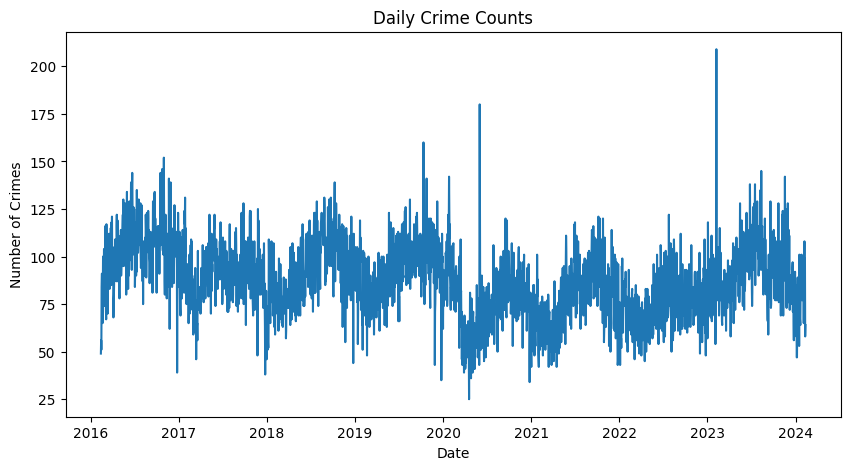

In [100]:
plt.figure(figsize = (10,5))
plt.plot(timeseries['Count'])
plt.title("Daily Crime Counts")
plt.xlabel('Date')
plt.ylabel('Number of Crimes')


# Save the plot
plt.savefig('TimeSeries1.jpg', format='jpeg', dpi=100)

plt.show()

/var/folders/c2/5fxpw5215nxfm047bjnsl7x40000gn/T/ipykernel_58251/1026286804.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(timeseries['Count'], kde = True)


Text(0, 0.5, 'Density')

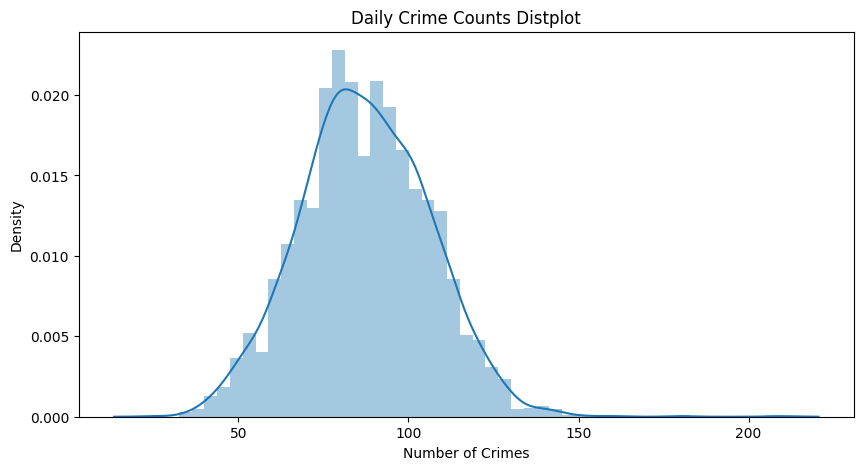

In [101]:
plt.figure(figsize = (10,5))
sns.distplot(timeseries['Count'], kde = True)
plt.title("Daily Crime Counts Distplot")
plt.xlabel('Number of Crimes')
plt.ylabel('Density')

### Stationarity ?

#### ADF (Augmented Dickey-Fuller) Test


The Dickey-Fuller test is one of the most extensively used statistical tests. It can be used to establish whether a series has a unit root and, as a result, whether the series is stationary. The null and alternate hypotheses for this test are: Distinguish between point to point links and multi point links Null Hypothesis: The series has a unit root (a =1).

Alternative Hypothesis: There is no unit root in the series.

The series is considered to be non-stationary if the null hypothesis is not rejected. As a result, the series can be linear or difference stationary. If both the mean and standard deviation are flat lines, the series becomes stationary (constant mean and constant variance).

In [102]:
timeseries['Count'].rolling(365).mean

<bound method Rolling.mean of Rolling [window=365,center=False,axis=0,method=single]>

Text(0, 0.5, 'Number of Crimes')

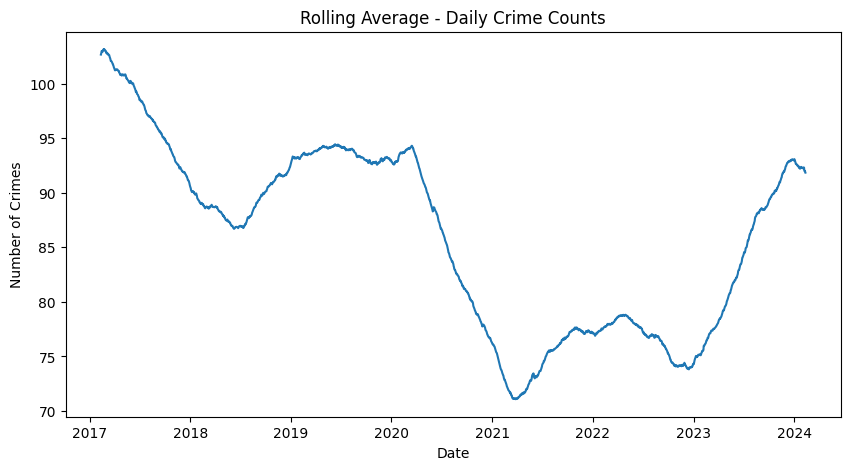

In [103]:
plt.figure(figsize = (10,5))
plt.plot(timeseries['Count'].rolling(365).mean())
plt.title("Rolling Average - Daily Crime Counts")
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

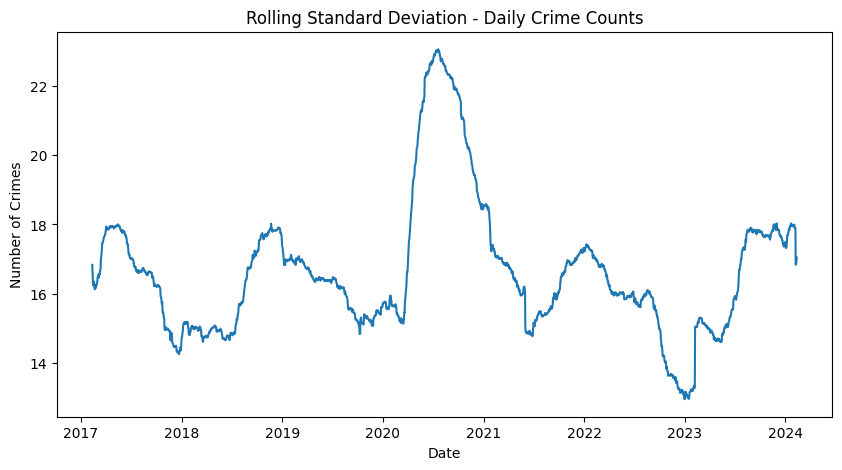

In [104]:
plt.figure(figsize = (10,5))
plt.plot(timeseries['Count'].rolling(365).std())
plt.title("Rolling Standard Deviation - Daily Crime Counts")
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

In [105]:
from statsmodels.tsa.stattools import adfuller

#Checking stationary
adfuller(timeseries['Count'],autolag='AIC')

(-3.1907268345437294,
 0.020527760332817713,
 27,
 2893,
 {'1%': -3.432612396049843,
  '5%': -2.8625395742539688,
  '10%': -2.5673021019579663},
 23248.24495540702)

In [106]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(timeseries['Count'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.1907268345437294
p-value: 0.020527760332817713
Critical Values:
   1%: -3.432612396049843
   5%: -2.8625395742539688
   10%: -2.5673021019579663


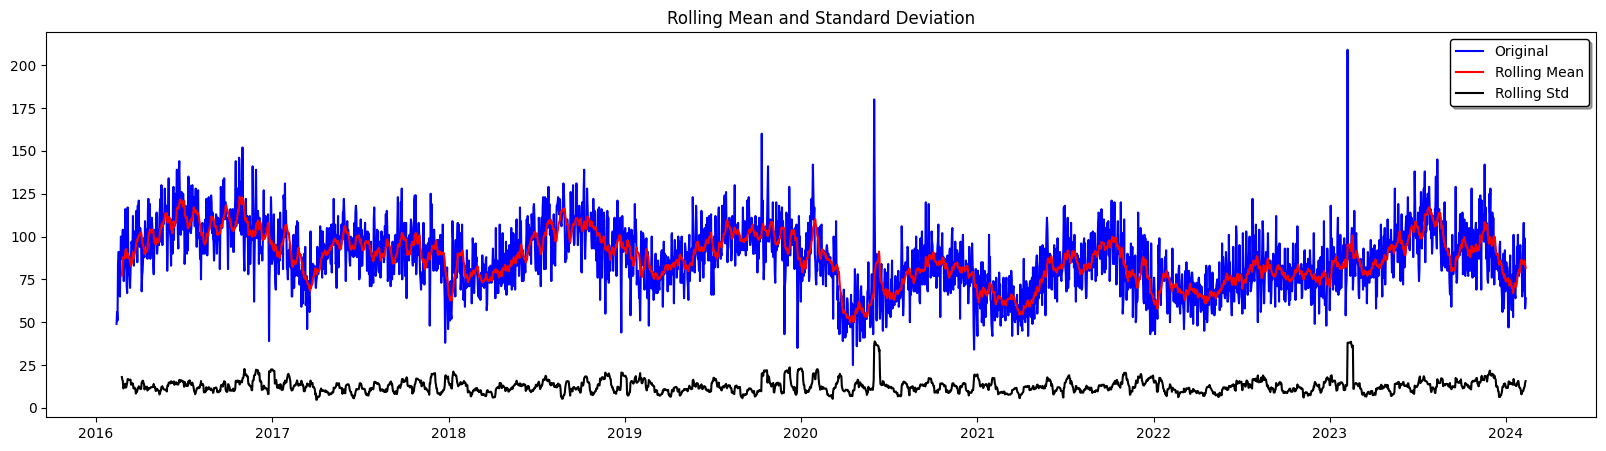


**************************************************
Results of dickey fuller test
Test Statistics                  -3.190727
p-value                           0.020528
No. of lags used                 27.000000
Number of observations used    2893.000000
critical value (1%)              -3.432612
critical value (5%)              -2.862540
critical value (10%)             -2.567302
dtype: float64

**************************************************


<Figure size 640x480 with 0 Axes>

In [107]:
#Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() # rolling mean of 12 days
    rolstd = timeseries.rolling(12).std() # rolling standard deviation
    # Plot rolling statistics:
    plt.figure(figsize = (20,5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', shadow=True,edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    print(f"\n{'*'*50}")
    # Save the plot
    plt.savefig('RollingMeanSD.jpg', format='jpeg', dpi=100)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    print(f"\n{'*'*50}")
# Function calling
test_stationarity(timeseries['Count'])

We can reject the Null hypothesis because our p-value here is smaller than 0.05. The test statistic here is quite negative, and that can lead us in the direction of rejecting the null hypothesis as well. It is also lower than the critical values. Our data is very likely to be stationary.

### Decompose the time series

##### Check the Trend, Seasonality and Residual

- Trend — general movement over time
- Seasonal — behaviours captured in individual seasonal periods
- Residual — everything not captured by trend and seasonal components

In [108]:
result=seasonal_decompose(timeseries[["Count"]],period = 30)

<Figure size 600x800 with 0 Axes>

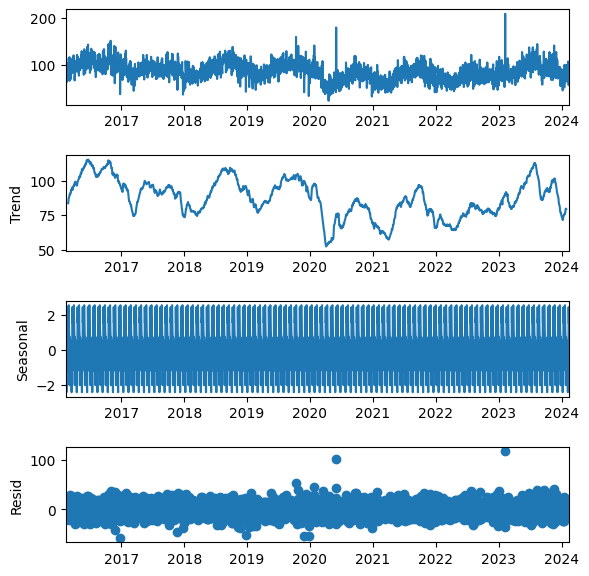

In [109]:
fig=plt.figure(figsize=(6,8))
fig=result.plot()
fig.set_size_inches(6,6)


# Save the plot
plt.savefig('PartsofTS.jpg', format='jpeg', dpi=100)

plt.show()



### ARIMA?

In [110]:
timeseries.shape

(2921, 1)

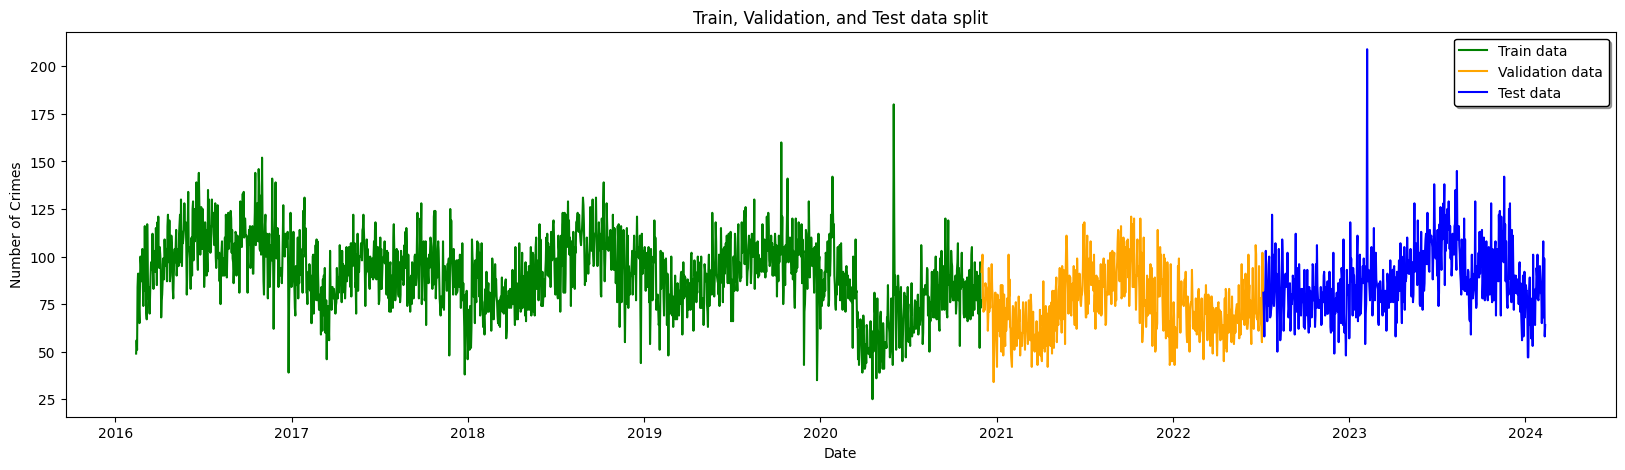

In [111]:
import matplotlib.pyplot as plt

# Define the split ratio
train_ratio = 0.6  # 60% of the data for training
val_ratio = 0.2    # 20% of the data for validation
test_ratio = 0.2   # 20% of the data for testing

# Calculate the number of data points in each set
train_size = int(len(timeseries) * train_ratio)
val_size = int(len(timeseries) * val_ratio)

# Split the data into train, validation, and test sets
train_data = timeseries[:train_size]
val_data = timeseries[train_size:train_size + val_size]
test_data = timeseries[train_size + val_size:]

# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(train_data, 'green', label='Train data')
plt.plot(val_data, 'orange', label='Validation data')
plt.plot(test_data, 'blue', label='Test data')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend(shadow=True, edgecolor='k')
plt.title('Train, Validation, and Test data split')


# Save the plot as an image file
plt.savefig('datasplit3.jpg', format='jpeg', dpi=100)


plt.show()


In [112]:
# #split data into train and training set
# train_data=timeseries[0:-730]
# test_data=timeseries[-730:]
# plt.figure(figsize=(20,5))
# plt.xlabel('Date')
# plt.ylabel('Number of Crimes')
# plt.plot(train_data, 'green', label='Train data')
# plt.plot(test_data, 'blue', label='Test data')
# plt.legend( shadow=True,edgecolor = 'k')

# plt.savefig('datasplit.jpg', format='jpeg', dpi=100)

# plt.show()

In [113]:
print(train_data.head())
print(val_data.head())
print(test_data.head())

             Count
Report_Date       
2016-02-13      49
2016-02-14      56
2016-02-15      51
2016-02-16      84
2016-02-17      91
             Count
Report_Date       
2020-11-30      92
2020-12-01      96
2020-12-02     101
2020-12-03      77
2020-12-04      71
             Count
Report_Date       
2022-07-07      81
2022-07-08      71
2022-07-09      58
2022-07-10      76
2022-07-11      84


In [114]:
print(train_data.tail())
print(val_data.tail())
print(test_data.tail())

             Count
Report_Date       
2020-11-25      90
2020-11-26      52
2020-11-27      97
2020-11-28      73
2020-11-29      77
             Count
Report_Date       
2022-07-02      65
2022-07-03      63
2022-07-04      55
2022-07-05     102
2022-07-06      75
             Count
Report_Date       
2024-02-07     108
2024-02-08      68
2024-02-09      99
2024-02-10      58
2024-02-11      64


In [115]:
val_data.head()

,Count
Report_Date,
2020-11-30,92
2020-12-01,96
2020-12-02,101
2020-12-03,77
2020-12-04,71


#### ACF and PACF Investigation

In [116]:
# Calculate autocorrelation
acf_values = acf(timeseries['Count'])
np.round(acf_values,2)

array([1.  , 0.61, 0.5 , 0.46, 0.46, 0.48, 0.51, 0.55, 0.49, 0.46, 0.44,
       0.42, 0.44, 0.49, 0.51, 0.46, 0.42, 0.41, 0.41, 0.42, 0.46, 0.48,
       0.44, 0.41, 0.39, 0.39, 0.41, 0.46, 0.47, 0.44, 0.4 , 0.39, 0.39,
       0.4 , 0.42])

In [117]:
# Calculate partial autocorrelation
acf_values = pacf(timeseries['Count'])
np.round(acf_values,2)

array([ 1.  ,  0.61,  0.22,  0.16,  0.15,  0.17,  0.18,  0.2 ,  0.03,
        0.04,  0.04,  0.01,  0.04,  0.12,  0.1 ,  0.  , -0.02,  0.01,
        0.02,  0.02,  0.07,  0.07, -0.01,  0.  , -0.02,  0.  ,  0.02,
        0.07,  0.07,  0.01, -0.02,  0.01,  0.  ,  0.  ,  0.01])

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


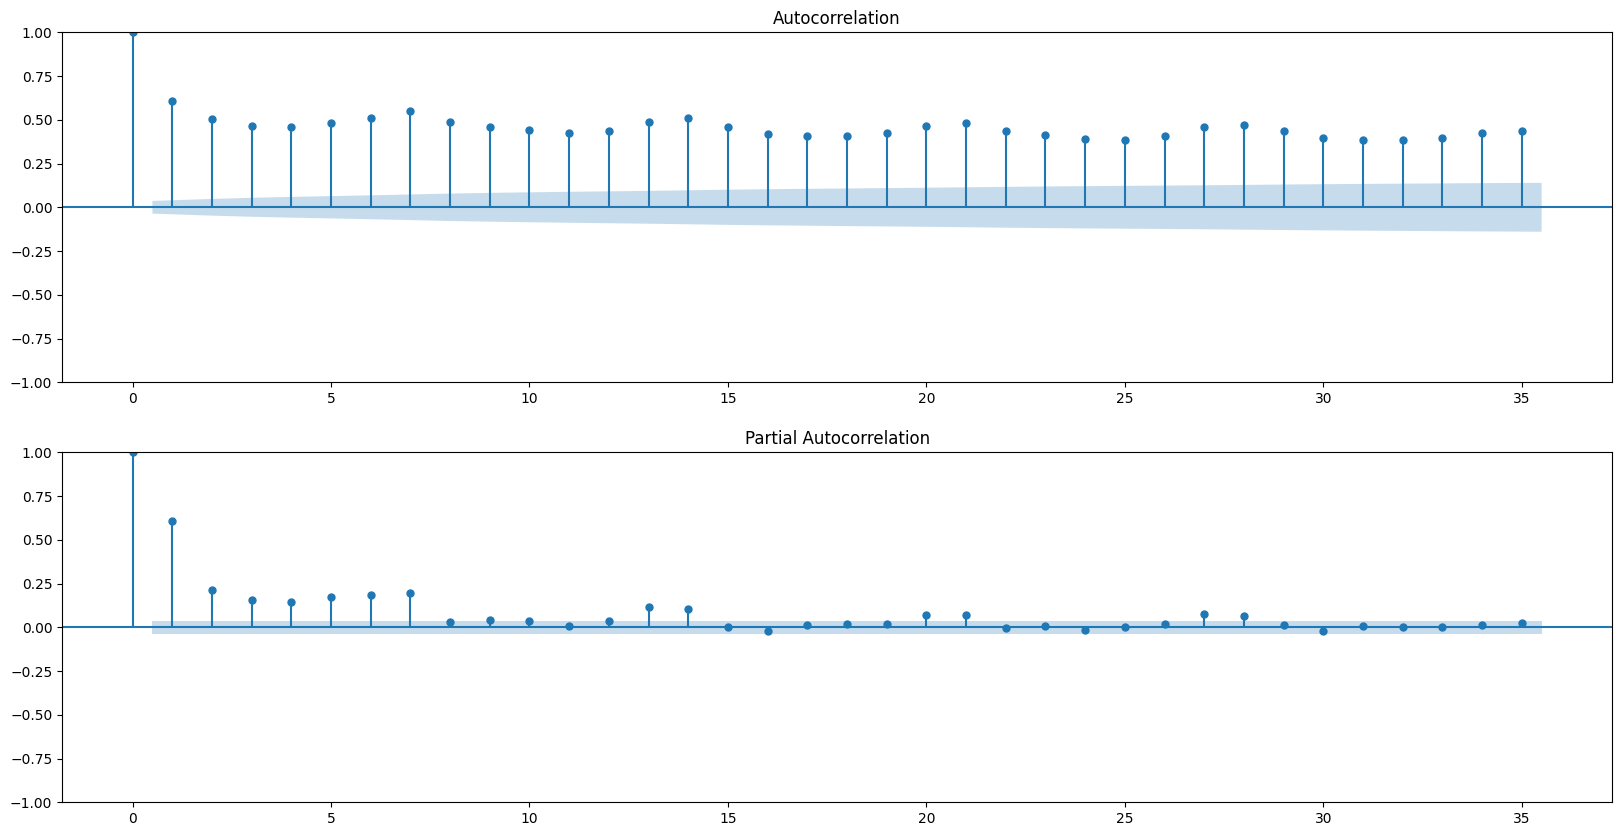

In [118]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)#function
fig = plot_acf(timeseries['Count'], ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(timeseries['Count'], ax=ax2)


# Save the plot
plt.savefig('ACF-PACF.jpg', format='jpeg', dpi=100)

In [119]:
# import itertools
# import numpy as np
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# # Define the range of p, d, and q values to search
# p_values = range(0, 3)
# d_values = range(0, 3)
# q_values = range(0, 3)

# # Initialize variables to store the best model and its RMSE
# best_model = None
# best_rmse = float('inf')
# best_order = None

# # Iterate over all combinations of p, d, and q values
# for p, d, q in itertools.product(p_values, d_values, q_values):
#     order = (p, d, q)
#     try:
#         # Fit ARIMA model
#         model = ARIMA(train_data, order=order)
#         model_fit = model.fit()

#         # Make predictions
#         predictions = model_fit.forecast(len(test_data))

#         # Calculate RMSE
#         rmse = np.sqrt(mean_squared_error(test_data, predictions))

#         # Update best model and RMSE if current RMSE is lower
#         if rmse < best_rmse:
#             best_model = model_fit
#             best_rmse = rmse
#             best_order = order

#         # Print current order and RMSE
#         print(f'ARIMA{order} RMSE: {rmse:.3f}')
#     except:
#         continue

# # Print best order and RMSE
# print(f'Best ARIMA order: {best_order}')
# print(f'Best RMSE: {best_rmse:.3f}')


In [120]:
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Define the range of p, d, and q values to search (ARIMA)
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Initialize variables then store the best model and its RMSE
best_model = None
best_rmse = float('inf')
best_order = None


# Iterate over all combinations of p, d, and q values
for p, d, q in itertools.product(p_values, d_values, q_values):
    order = (p, d, q)
    try:
        # Fit ARIMA model on the training data
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        # Make predictions on the validation set
        predictions = model_fit.forecast(len(val_data))

        # Calculate RMSE on the validation set
        rmse = np.sqrt(mean_squared_error(val_data, predictions))

        # Update best model and RMSE if current RMSE is lower
        if rmse < best_rmse:
            best_model = model_fit
            best_rmse = rmse
            best_order = order

        # Print order and RMSE
        print(f'ARIMA{order} RMSE on Validation Set: {rmse:.2f}')
    except:
        continue

# Print best order and RMSE on the validation set
print(f'Best ARIMA order based on Validation Set: {best_order}')
print(f'Best RMSE on Validation Set: {best_rmse:.2f}')


# Train the best ARIMA model on the combined training and validation data
final_model = ARIMA(np.concatenate((train_data, val_data)), order=best_order)
final_model_fit = final_model.fit()

# Make predictions on the test set and calculate RMSE
test_predictions = final_model_fit.forecast(len(test_data))
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))

print(f'For the Final model trained on training + validation data')
print(f'RMSE on Test Set: {test_rmse:.2f}')


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) RMSE on Validation Set: 22.90
ARIMA(0, 0, 1) RMSE on Validation Set: 22.90


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(0, 0, 2) RMSE on Validation Set: 22.90
ARIMA(0, 1, 0) RMSE on Validation Set: 16.06
ARIMA(0, 1, 1) RMSE on Validation Set: 16.31


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(0, 1, 2) RMSE on Validation Set: 16.64
ARIMA(0, 2, 0) RMSE on Validation Set: 1352.31
ARIMA(0, 2, 1) RMSE on Validation Set: 17.37


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(0, 2, 2) RMSE on Validation Set: 16.59
ARIMA(1, 0, 0) RMSE on Validation Set: 22.86


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(1, 0, 1) RMSE on Validation Set: 21.80


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) RMSE on Validation Set: 20.62
ARIMA(1, 1, 0) RMSE on Validation Set: 15.95


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(1, 1, 1) RMSE on Validation Set: 16.71


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) RMSE on Validation Set: 16.70
ARIMA(1, 2, 0) RMSE on Validation Set: 2166.08


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(1, 2, 1) RMSE on Validation Set: 16.81


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 2) RMSE on Validation Set: 16.60


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0) RMSE on Validation Set: 22.83


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) RMSE on Validation Set: 20.42


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) RMSE on Validation Set: 20.45
ARIMA(2, 1, 0) RMSE on Validation Set: 16.46


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(2, 1, 1) RMSE on Validation Set: 16.70


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) RMSE on Validation Set: 16.71
ARIMA(2, 2, 0) RMSE on Validation Set: 527.08


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

ARIMA(2, 2, 1) RMSE on Validation Set: 18.38


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.p

ARIMA(2, 2, 2) RMSE on Validation Set: 16.58
Best ARIMA order based on Validation Set: (1, 1, 0)
Best RMSE on Validation Set: 15.95
For the Final model trained on training + validation data
RMSE on Test Set: 18.23


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [121]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the ARIMA model with the appropriate order
p = 1  # Autoregressive order
d = 1  # Differencing order
q = 0 # Moving average order
model = ARIMA(train_data, order=(p, d, q))

# Fit the ARIMA model
model_fit = model.fit()

# Evaluate the model on the validation set
validation_predictions = model_fit.forecast(len(val_data))

# Calculate RMSE on the validation set
validation_rmse = np.sqrt(mean_squared_error(val_data, validation_predictions))

print(f'Validation RMSE: {validation_rmse:.2f}')

# After tuning your model using the validation set, refit the model using the combined training and validation data
combined_data = np.concatenate((train_data, val_data))
model_final = ARIMA(combined_data, order=(p, d, q))
model_final_fit = model_final.fit()

# Evaluate the model on the test set
test_predictions = model_final_fit.forecast(len(test_data))

# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))

print(f'Test RMSE: {test_rmse:.2f}')


# Display model summary
print(model_final_fit.summary())


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Validation RMSE: 15.95
Test RMSE: 18.23
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2336
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9678.573
Date:                Wed, 01 May 2024   AIC                          19361.146
Time:                        17:41:02   BIC                          19372.658
Sample:                             0   HQIC                         19365.340
                               - 2336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3554      0.018    -20.266      0.000      -0.390      -0.321
sigma2       233.3200      5.667     41.173      0.000     222.213     244.427
Ljung-Box (L

In [122]:
AIC_arima = 19361.146

In [123]:
# from statsmodels.tsa.arima.model import ARIMA

# # Define the ARIMA model with the appropriate order
# p = 2  # Autoregressive order
# d = 0  # Differencing order
# q = 1 # Moving average order
# model = ARIMA(train_data, order=(p, d, q))

# # Fit the ARIMA model
# model_fit = model.fit()

# # Print a summary of the fitted model
# print(model_fit.summary())

# # Get the residuals (errors) of the model
# residuals = model_fit.resid

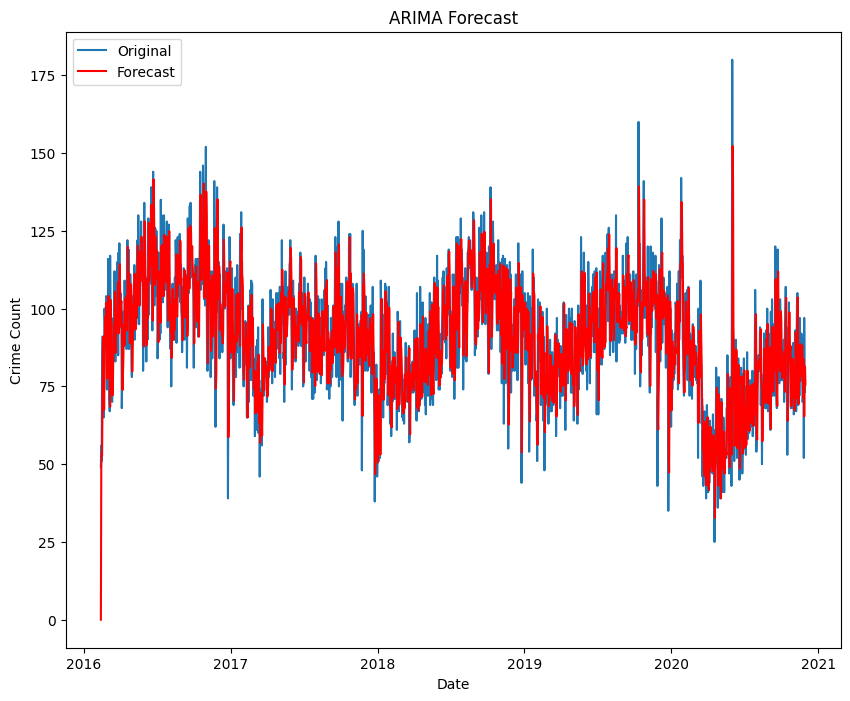

In [124]:
# Define the start and end dates for the forecast
start_date = '2016-02-13'
end_date = '2020-11-30'

# Make the forecast
forecast1 = model_fit.predict(start=start_date, end=end_date, dynamic=False)

# Plot the original time series and the forecast
plt.figure(figsize=(10, 8))
plt.plot(train_data.index, train_data['Count'], label='Original')
plt.plot(forecast1.index, forecast1, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

2020-11-30    79.135184
2020-12-01    79.661380
2020-12-02    79.772355
2020-12-03    79.793817
2020-12-04    79.797051
                ...    
2022-07-02    79.053510
2022-07-03    79.052215
2022-07-04    79.050920
2022-07-05    79.049624
2022-07-06    79.048329
Freq: D, Name: predicted_mean, Length: 584, dtype: float64
Length of predictions: 584
Length of test data: 585


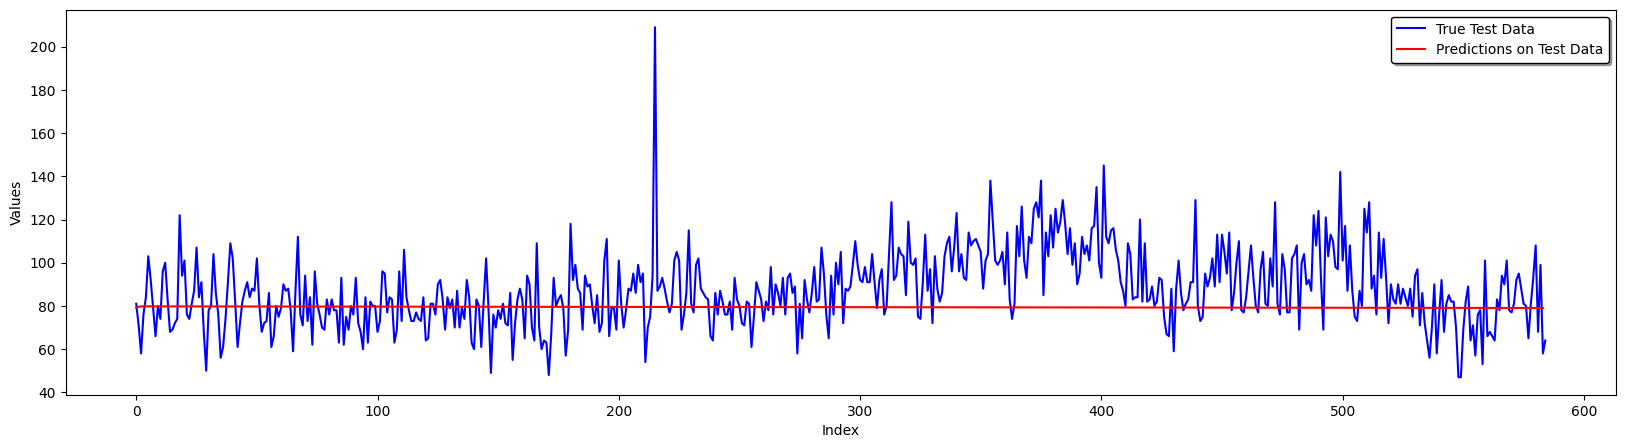

In [125]:
import matplotlib.pyplot as plt

# Print the predictions variable to inspect its contents
print(predictions)

# Check the lengths of the predictions and test data
print(f"Length of predictions: {len(predictions)}")
print(f"Length of test data: {len(test_data)}")

# Adjust the plot
plt.figure(figsize=(20, 5))

# Plot the test data
plt.plot(range(len(test_data)), test_data, label='True Test Data', color='blue')

# Plot the predictions, assuming they start from the same index as the test data
plt.plot(range(len(predictions)), predictions, label='Predictions on Test Data', color='red')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend(shadow=True, edgecolor='k')

# Show the plot
plt.show()


In [126]:
# # Print the predictions variable to inspect its contents
# print(predictions)

# # Plot the true test values and predictions
# plt.figure(figsize=(20,5))
# plt.plot(range(len(test_data)), test_data, label='True Test Close Value')
# plt.plot(range(len(predictions)), predictions, label='Predictions on test data')
# plt.legend(shadow=True, edgecolor='k')
# plt.show()


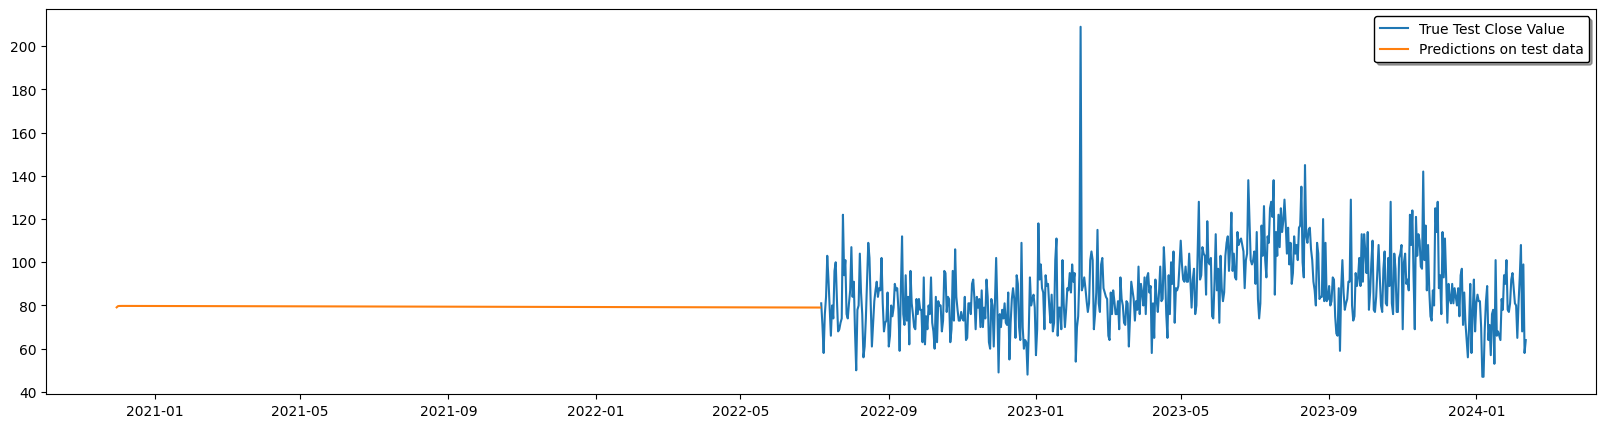

In [127]:
# Plot the true test values and predictions
plt.figure(figsize=(20,5))
plt.plot(test_data.index, test_data, label='True Test Close Value')
plt.plot(predictions.index, predictions, label='Predictions on test data')
plt.legend(shadow=True, edgecolor='k')
plt.show()


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


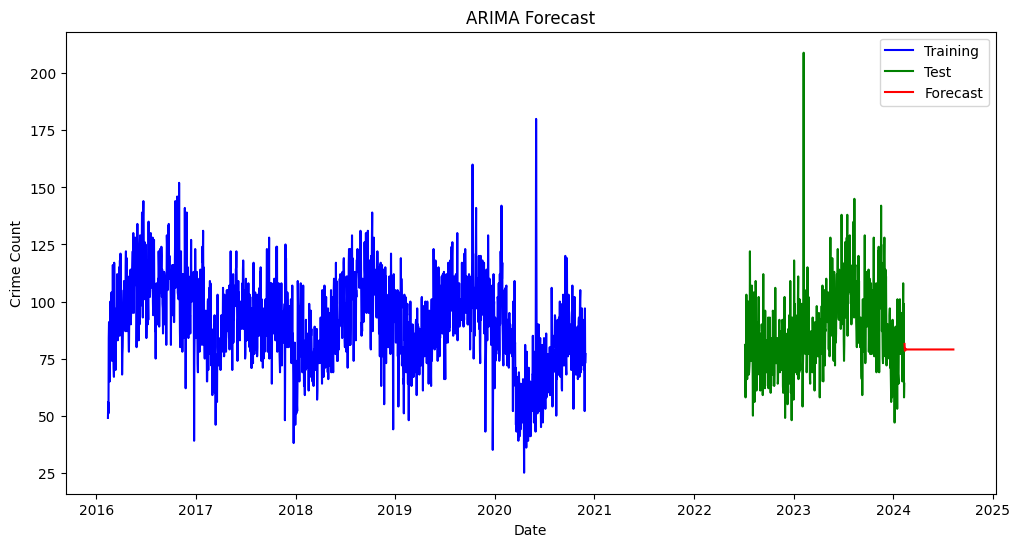

In [128]:
from statsmodels.tsa.arima.model import ARIMA

# Train the ARIMA model on the training dataset
model = ARIMA(train_data, order=(2, 1, 0))  # Use the appropriate order for your dataset
model_fit = model.fit()

# Forecast future values for 6 months
forecast_steps = 180  # Assuming daily data, 6 months = 180 days
start_date = test_data.index[-1] + pd.Timedelta(days=1)  # Start forecast from the day after the last day of the test data
forecast_index = pd.date_range(start=start_date, periods=forecast_steps)

# Forecast future values
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the training, test, and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training', color='blue')
plt.plot(test_data.index, test_data, label='Test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()


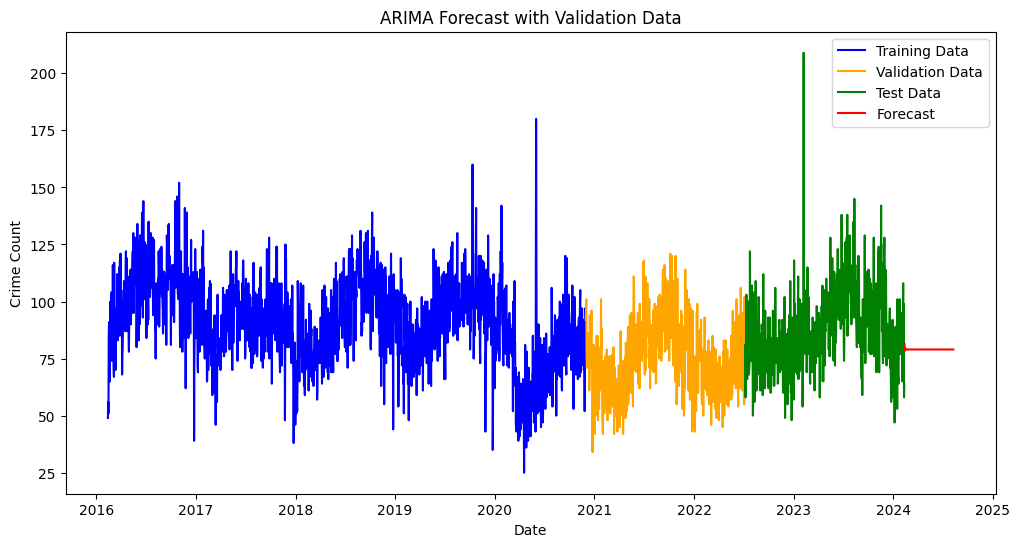

In [129]:
import matplotlib.pyplot as plt

# Check if the lengths of data and indices match
assert len(val_data) > 0, "length of Validation data is zero."
assert val_data.index.is_unique, "Validation data index is not unique."

# Plot training, validation, test, and forecasted data
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(train_data.index, train_data, label='Training Data', color='blue')

# Plot the validation data
plt.plot(val_data.index, val_data, label='Validation Data', color='orange')

# Plot the test data
plt.plot(test_data.index, test_data, label='Test Data', color='green')

# Forecast future values for 6 months (180 days) using the final ARIMA model
forecast_steps = 180
start_date = test_data.index[-1] + pd.Timedelta(days=1)
forecast_index = pd.date_range(start=start_date, periods=forecast_steps)

# Forecast future values
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the forecasted data
plt.plot(forecast_index, forecast, label='Forecast', color='red')

# Add labels and legend
plt.title('ARIMA Forecast with Validation Data')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()

# Show the plot
plt.show()


In [130]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# # Assuming `test_data` contains the actual values of the test set and `predictions` contains the forecasted values
# # Calculate Mean Absolute Error (MAE)
# mae = mean_absolute_error(test_data, arima_predictions)

# # Calculate Mean Squared Error (MSE)
# mse = mean_squared_error(test_data, arima_predictions)

# # Calculate Mean Absolute Percentage Error (MAPE)
# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# mape = mean_absolute_percentage_error(test_data, predictions)

# print("Mean Absolute Error (MAE):", mae)
# print("Mean Squared Error (MSE):", mse)
# print("Mean Absolute Percentage Error (MAPE):", mape)


### Maybe Seasonality? SARIMA...

In [131]:
# import itertools
# import warnings
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error

# # Define the SARIMA parameters to search
# p_values = range(0, 3)  # range for AR parameter
# d_values = range(0, 2)  # range for differencing parameter
# q_values = range(0, 3)  # range for MA parameter
# P_values = range(0, 3)  # range for seasonal AR parameter
# D_values = range(0, 2)  # range for seasonal differencing parameter
# Q_values = range(0, 3)  # range for seasonal MA parameter
# m = 7  # seasonal period

# # Create a list of all possible parameter combinations
# param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

# # Perform grid search
# best_rmse = float('inf')
# best_params = None

# for param in param_grid:
#     try:
#         # Fit SARIMA model with current parameters
#         model = SARIMAX(train_data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], m))
#         model_fit = model.fit(disp=False)
        
#         # Make predictions
#         sarima_predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        
#         # Calculate RMSE
#         rmse = np.sqrt(mean_squared_error(test_data, sarima_predictions))
        
#         # Update best parameters if RMSE is improved
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_params = param
            
#     except:
#         continue

# print("Best SARIMA parameters:", best_params)
# print("Best RMSE:", best_rmse)


In [132]:
import itertools
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define the SARIMA parameters to search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
m = 7  # seasonal period (weekly seasonality)

# Initialize best parameters and RMSE
best_rmse = float('inf')
best_params = None

# Perform grid search
for param in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], m)

    try:
        # Fit SARIMA model using the training data
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)

        # Make predictions on the validation set
        start = len(train_data)
        end = start + len(val_data) - 1
        predictions = model_fit.predict(start=start, end=end)

        # Calculate RMSE on the validation set
        rmse = np.sqrt(mean_squared_error(val_data, predictions))

        # Update best parameters and RMSE if current RMSE is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (order, seasonal_order)

    except:
        continue

print(f'Best SARIMA parameters: {best_params}')
print(f'Best RMSE on validation set: {best_rmse:.3f}')

# Train the final model on the combined training and validation data
train_val_data = train_data.append(val_data)
model_final = SARIMAX(train_val_data, order=best_params[0], seasonal_order=best_params[1])
model_final_fit = model_final.fit(disp=False)

# Make predictions on the test set
start = len(train_val_data)
end = start + len(test_data) - 1
test_predictions = model_final_fit.predict(start=start, end=end)

# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))

print(f'Final SARIMA model RMSE on test set: {test_rmse:.3f}')


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No freque

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No freque

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No freque

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No freque

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No freque

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization

/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

Best SARIMA parameters: ((2, 0, 0), (2, 0, 1, 7))
Best RMSE on validation set: 15.470


/var/folders/c2/5fxpw5215nxfm047bjnsl7x40000gn/T/ipykernel_58251/4099286983.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_val_data = train_data.append(val_data)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Final SARIMA model RMSE on test set: 25.388


In [133]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Tune the model using the validation set
order = (2, 0, 0)
seasonal_order = (2, 0, 1, 7)
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

# Fit the model on the training data
model_fit = model.fit(disp=False)

# Make predictions on the validation set
start = len(train_data)
end = start + len(val_data) - 1
predictions = model_fit.predict(start=start, end=end)

# Calculate RMSE on the validation set
rmse = np.sqrt(mean_squared_error(val_data, predictions))
print(f'Validation RMSE: {rmse:.3f}')

# Assuming best order and seasonal order found from the tuning process
best_order = order
best_seasonal_order = seasonal_order

# Train the final SARIMA model using combined training and validation data
train_val_data = pd.concat([train_data, val_data])
model_final = SARIMAX(train_val_data, order=best_order, seasonal_order=best_seasonal_order)
model_final_fit_sarima = model_final.fit(disp=False)

# Evaluate the model on the test set
start = len(train_val_data)
end = start + len(test_data) - 1
test_predictions = model_final_fit_sarima.predict(start=start, end=end)

# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
print(f'Final SARIMA model RMSE on test set: {test_rmse:.3f}')


# Display model summary
print(model_final_fit_sarima.summary())


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Validation RMSE: 15.470


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Final SARIMA model RMSE on test set: 25.388
                                      SARIMAX Results                                      
Dep. Variable:                               Count   No. Observations:                 2336
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 7)   Log Likelihood               -9414.454
Date:                             Wed, 01 May 2024   AIC                          18840.907
Time:                                     17:51:34   BIC                          18875.445
Sample:                                 02-13-2016   HQIC                         18853.489
                                      - 07-06-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3733      0.019     19.606      0.000       0

In [134]:
AIC_sarima = 18840.907

In [135]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Define the SARIMA model with the best parameters
# order = (2, 0, 0)
# seasonal_order = (2, 0, 1, 7)  # Assuming a weekly seasonal pattern
# sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

# # Fit the SARIMA model
# sarima_model_fit = sarima_model.fit()

# # Display model summary
# print(sarima_model_fit.summary())


In [136]:
val_data.head()

,Count
Report_Date,
2020-11-30,92
2020-12-01,96
2020-12-02,101
2020-12-03,77
2020-12-04,71


In [137]:
train_data.tail()

,Count
Report_Date,
2020-11-25,90
2020-11-26,52
2020-11-27,97
2020-11-28,73
2020-11-29,77


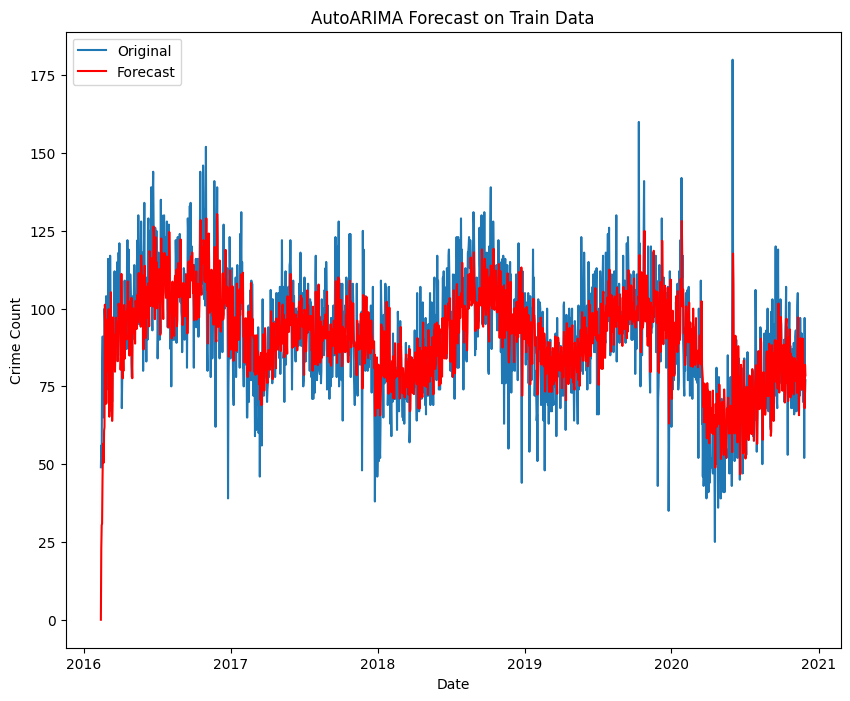

In [138]:
# Define the start and end dates for the forecast
start_date = '2016-02-13'
end_date = '2020-11-29'

# Make the forecast
forecast2 = model_final_fit.predict(start=start_date, end=end_date, dynamic=False)

# Plot the original time series and the forecast
plt.figure(figsize=(10, 8))
plt.plot(train_data.index, train_data['Count'], label='Original')
plt.plot(forecast2.index, forecast2, label='Forecast', color='red')
plt.title('AutoARIMA Forecast on Train Data')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()

plt.savefig('Auto-Train.jpg', format='jpeg', dpi=100)


plt.show()

In [139]:
test_data.tail()

,Count
Report_Date,
2024-02-07,108
2024-02-08,68
2024-02-09,99
2024-02-10,58
2024-02-11,64


In [140]:
# # Define the start and end dates for the forecast
# start_date = '2022-02-12'
# end_date = '2024-02-11'

# # Make the forecast
# forecast5 = model_final_fit.predict(start=start_date, end=end_date, dynamic=False)

# # Plot the original time series and the forecast
# plt.figure(figsize=(10, 8))
# plt.plot(test_data.index, test_data['Count'], label='Original')
# plt.plot(forecast5.index, forecast5, label='Forecast', color='red')
# plt.title('SARIMA Forecast on Test Data')
# plt.xlabel('Date')
# plt.ylabel('Crime Count')
# plt.legend()

# plt.savefig('SARIMA-test.jpg', format='jpeg', dpi=100)


# plt.show()

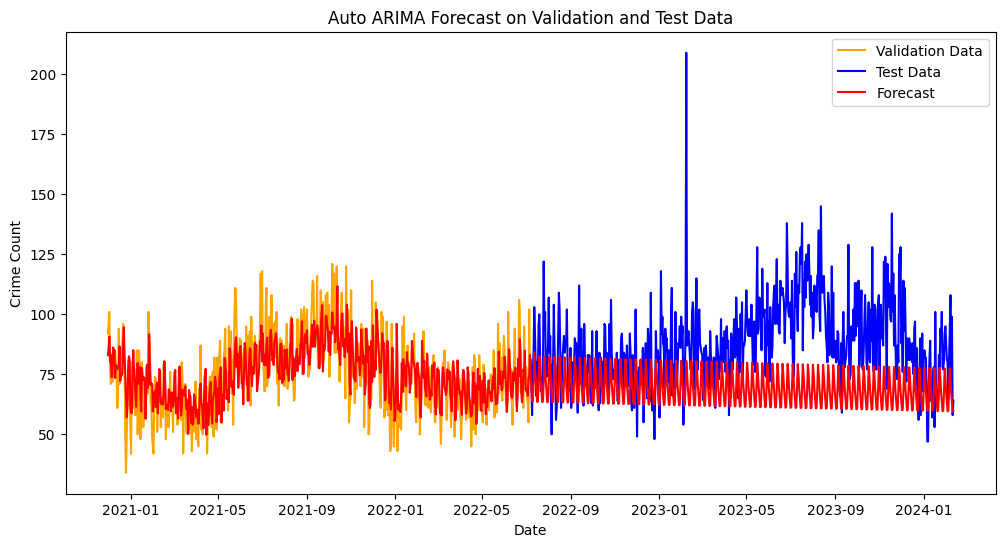

In [141]:
# Define the forecast start and end dates
start_date = val_data.index[0]  # Start forecasting from the first date of the validation set
end_date = test_data.index[-1]  # Forecast until the last date of the test set

# Make the forecast
forecast = model_final_fit.predict(start=start_date, end=end_date, dynamic=False)

# Plot the original time series (validation and test data) and the forecast
plt.figure(figsize=(12, 6))

# Plot the original validation and test data
plt.plot(val_data.index, val_data['Count'], label='Validation Data', color='orange')
plt.plot(test_data.index, test_data['Count'], label='Test Data', color='blue')

# Plot the forecasted data
plt.plot(forecast.index, forecast, label='Forecast', color='red')

# Add labels, title, and legend
plt.title('Auto ARIMA Forecast on Validation and Test Data')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()

# Save the plot
plt.savefig('AutoARIMA-validation-test-forecast.jpg', format='jpeg', dpi=100)

# Display the plot
plt.show()


### Auto ARIMA

In [142]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the number of cross-validation folds
n_splits = 5  # Adjust this value as needed

# Fit the auto ARIMA model using time series cross-validation
auto_arima_model = pm.auto_arima(
    train_data,
    seasonal=False,
    stepwise=True,
    trace=True,
    cv=n_splits,  # Specify the number of cross-validation folds
    error_action='ignore',
    suppress_warnings=True
)

# Print a summary of the auto ARIMA model
print(auto_arima_model.summary())

# Forecast future values for the test set
start_date = test_data.index[0]
end_date = test_data.index[-1]
auto_forecast = auto_arima_model.predict(n_periods=len(test_data), return_conf_int=True)

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(test_data, auto_forecast[0]))
print(f'Auto ARIMA model RMSE on test set: {rmse:.3f}')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14141.175, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14790.696, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14562.158, Time=0.06 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14240.691, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14788.697, Time=0.03 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14145.344, Time=0.38 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14145.306, Time=0.33 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14149.305, Time=0.93 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14143.130, Time=0.97 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14143.657, Time=0.25 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14147.192, Time=0.60 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14146.779, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14151.601, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=14139.175, Time=0.30 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14143.344, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14143.306, Time=0.17 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=14141.114, Time=0.89 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=14141.130, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14141.657, Time=0.15 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=14145.192, Time=0.35 sec


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=14144.779, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=14149.601, Time=0.32 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.476 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1752
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7064.587
Date:                Wed, 01 May 2024   AIC                          14139.175
Time:                        17:51:43   BIC                          14166.515
Sample:                    02-13-2016   HQIC                         14149.281
                         - 11-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [143]:
AIC_auto = 14139.175

In [144]:
# import pmdarima as pm

# # Fit the auto ARIMA model
# auto_arima_model = pm.auto_arima(train_data, seasonal=False, trace=True)

# # Summary of the auto ARIMA model
# print(auto_arima_model.summary())


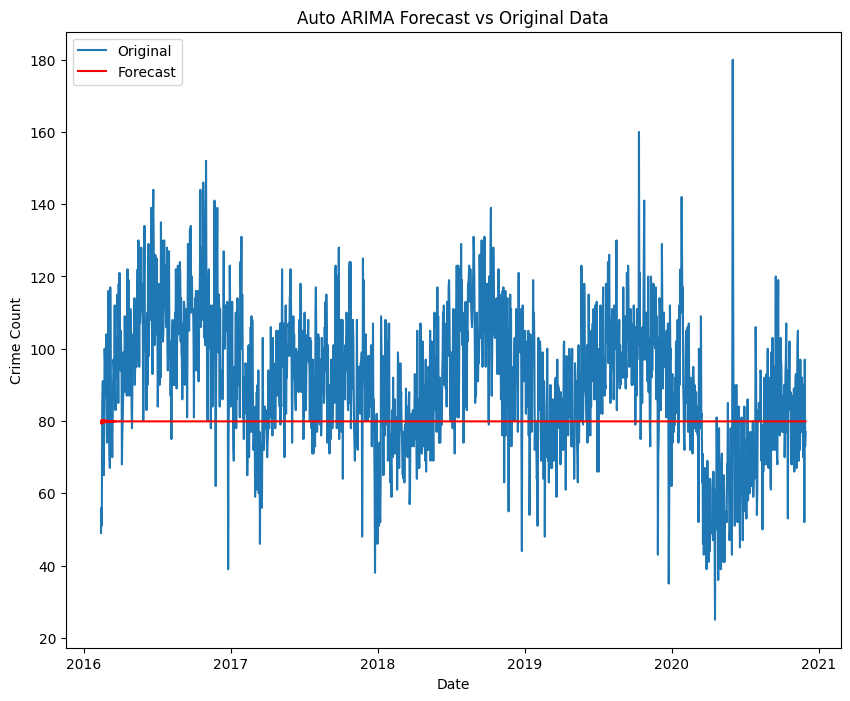

In [145]:
import matplotlib.pyplot as plt

# Define the start and end dates for the forecast
start_date = '2016-02-13'
end_date = '2020-11-29'

# Calculate the number of periods to forecast
forecast_periods = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1

# Make the forecast using the Auto ARIMA model
forecast2 = auto_arima_model.predict(n_periods=forecast_periods)

# Create a date range for the forecasted values
forecast_dates = pd.date_range(start=start_date, end=end_date)

# Plot the original data and the forecast
plt.figure(figsize=(10, 8))
plt.plot(train_data.index, train_data['Count'], label='Original')
plt.plot(forecast_dates, forecast2, label='Forecast', color='red')
plt.title('Auto ARIMA Forecast vs Original Data')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()

# Save the plot as a JPEG image
plt.savefig('Auto_ARIMA_train_forecast.jpg', format='jpeg', dpi=100)

# Display the plot
plt.show()



### Model Eval

#### ARIMA

In [146]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# # Forecast using ARIMA model
# forecast_arima = model_fit.forecast(steps=len(test_data))

# # Calculate metrics for ARIMA
# mae_arima = mean_absolute_error(test_data, forecast_arima)
# mse_arima = mean_squared_error(test_data, forecast_arima)
# mape_arima = np.mean(np.abs((test_data - forecast_arima) / test_data)) * 100

# print("ARIMA Metrics:")
# print(f"Mean Absolute Error (MAE): {mae_arima:.2f}")
# print(f"Mean Squared Error (MSE): {mse_arima:.2f}")
# #print(f"Mean Absolute Percentage Error (MAPE): {mape_arima:.2f}%")


In [147]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Forecast using ARIMA model on the validation set
forecast_val = model_fit.forecast(steps=len(val_data))

# Calculate metrics for ARIMA on the validation set
mae_arima_val = mean_absolute_error(val_data, forecast_val)
mse_arima_val = mean_squared_error(val_data, forecast_val)
mape_arima_val = np.mean(np.abs((val_data - forecast_val) / val_data)) * 100

print("ARIMA Metrics on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_arima_val:.2f}")
print(f"Mean Squared Error (MSE): {mse_arima_val:.2f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_val:.2f}%")

# Forecast using ARIMA model on the test set
forecast_test = model_fit.forecast(steps=len(test_data))

# Calculate metrics for ARIMA on the test set
mae_arima_test = mean_absolute_error(test_data, forecast_test)
mse_arima_test = mean_squared_error(test_data, forecast_test)
mape_arima_test = np.mean(np.abs((test_data - forecast_test) / test_data)) * 100

print("\nARIMA Metrics on Test Set:")
print(f"Mean Absolute Error (MAE): {mae_arima_test:.2f}")
print(f"Mean Squared Error (MSE): {mse_arima_test:.2f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%")


ARIMA Metrics on Validation Set:
Mean Absolute Error (MAE): 12.48
Mean Squared Error (MSE): 239.33

ARIMA Metrics on Test Set:
Mean Absolute Error (MAE): 16.03
Mean Squared Error (MSE): 454.36


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


#### SARIMA

In [148]:
# # Forecast using SARIMA model
# forecast_sarima = sarima_model_fit.forecast(steps=len(test_data))

# # Calculate metrics for SARIMA
# mae_sarima = mean_absolute_error(test_data, forecast_sarima)
# mse_sarima = mean_squared_error(test_data, forecast_sarima)
# mape_sarima = np.mean(np.abs((test_data - forecast_sarima) / test_data)) * 100

# print("SARIMA Metrics:")
# print(f"Mean Absolute Error (MAE): {mae_sarima:.2f}")
# print(f"Mean Squared Error (MSE): {mse_sarima:.2f}")
# #print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima:.2f}%")


In [149]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Forecast using SARIMA model on the validation set
start_val_date = len(train_data)
end_val_date = start_val_date + len(val_data) - 1
forecast_val = model_final_fit_sarima.predict(start=start_val_date, end=end_val_date)

# Calculate metrics for SARIMA on the validation set
mae_sarima_val = mean_absolute_error(val_data, forecast_val)
mse_sarima_val = mean_squared_error(val_data, forecast_val)
mape_sarima_val = np.mean(np.abs((val_data - forecast_val) / val_data)) * 100

print("SARIMA Metrics on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_sarima_val:.2f}")
print(f"Mean Squared Error (MSE): {mse_sarima_val:.2f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima_val:.2f}%")

# Forecast using SARIMA model on the test set
forecast_test = model_final_fit_sarima.forecast(steps=len(test_data))

# Calculate metrics for SARIMA on the test set
mae_sarima_test = mean_absolute_error(test_data, forecast_test)
mse_sarima_test = mean_squared_error(test_data, forecast_test)
mape_sarima_test = np.mean(np.abs((test_data - forecast_test) / test_data)) * 100

print("\nSARIMA Metrics on Test Set:")
print(f"Mean Absolute Error (MAE): {mae_sarima_test:.2f}")
print(f"Mean Squared Error (MSE): {mse_sarima_test:.2f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima_test:.2f}%")


SARIMA Metrics on Validation Set:
Mean Absolute Error (MAE): 9.79
Mean Squared Error (MSE): 153.70

SARIMA Metrics on Test Set:
Mean Absolute Error (MAE): 19.96
Mean Squared Error (MSE): 644.55


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


#### Auto ARIMA

In [150]:
# # Forecast using Auto ARIMA model
# forecast_auto_arima = auto_arima_model.predict(n_periods=len(test_data))

# # Calculate metrics for Auto ARIMA
# mae_auto_arima = mean_absolute_error(test_data, forecast_auto_arima)
# mse_auto_arima = mean_squared_error(test_data, forecast_auto_arima)
# mape_auto_arima = np.mean(np.abs((test_data - forecast_auto_arima) / test_data)) * 100

# print("Auto ARIMA Metrics:")
# print(f"Mean Absolute Error (MAE): {mae_auto_arima:.2f}")
# print(f"Mean Squared Error (MSE): {mse_auto_arima:.2f}")
# #print(f"Mean Absolute Percentage Error (MAPE): {mape_auto_arima:.2f}%")


In [151]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Forecast using Auto ARIMA model on the validation set
forecast_val = auto_arima_model.predict(n_periods=len(val_data))

# Calculate metrics for Auto ARIMA on the validation set
mae_auto_arima_val = mean_absolute_error(val_data, forecast_val)
mse_auto_arima_val = mean_squared_error(val_data, forecast_val)
mape_auto_arima_val = np.mean(np.abs((val_data - forecast_val) / val_data)) * 100

print("Auto ARIMA Metrics on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_auto_arima_val:.2f}")
print(f"Mean Squared Error (MSE): {mse_auto_arima_val:.2f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_auto_arima_val:.2f}%")

# Forecast using Auto ARIMA model on the test set
forecast_test = auto_arima_model.predict(n_periods=len(test_data))

# Calculate metrics for Auto ARIMA on the test set
mae_auto_arima_test = mean_absolute_error(test_data, forecast_test)
mse_auto_arima_test = mean_squared_error(test_data, forecast_test)
mape_auto_arima_test = np.mean(np.abs((test_data - forecast_test) / test_data)) * 100

print("\nAuto ARIMA Metrics on Test Set:")
print(f"Mean Absolute Error (MAE): {mae_auto_arima_test:.2f}")
print(f"Mean Squared Error (MSE): {mse_auto_arima_test:.2f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_auto_arima_test:.2f}%")


Auto ARIMA Metrics on Validation Set:
Mean Absolute Error (MAE): 13.70
Mean Squared Error (MSE): 279.39

Auto ARIMA Metrics on Test Set:
Mean Absolute Error (MAE): 14.09
Mean Squared Error (MSE): 361.01


/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Ore/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [152]:
import pandas as pd

# Create a dictionary with the MAE and MSE values for each model
model_metrics = {
    'Model': ['ARIMA', 'SARIMA', 'Auto ARIMA'],
    'MAE': [mae_arima_test, mae_sarima_test, mae_auto_arima_test],
    'MSE': [mse_arima_test, mse_sarima_test, mse_auto_arima_test],
    'AIC': [AIC_arima, AIC_sarima, AIC_auto]
}

# Create a data frame from the dictionary
metrics_df = pd.DataFrame(model_metrics)

# Set the index of the data frame to be the model names
metrics_df.set_index('Model', inplace=True)

# Display the data frame
print(metrics_df)


                  MAE         MSE        AIC
Model                                       
ARIMA       16.025171  454.364731  19361.146
SARIMA      19.960186  644.551978  18840.907
Auto ARIMA  14.090701  361.011670  14139.175


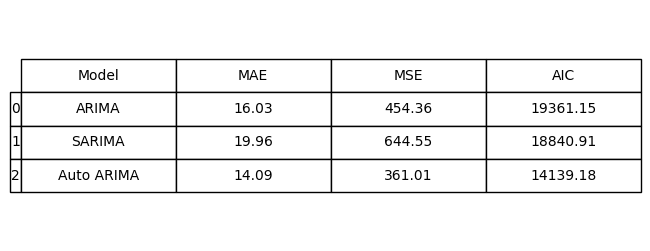

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the MAE and MSE values for each model
model_metrics = {
    'Model': ['ARIMA', 'SARIMA', 'Auto ARIMA'],
    'MAE': [mae_arima_test, mae_sarima_test, mae_auto_arima_test],
    'MSE': [mse_arima_test, mse_sarima_test, mse_auto_arima_test],
    'AIC': [AIC_arima, AIC_sarima, AIC_auto]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(model_metrics)

# Round the DataFrame values to 2 decimal places
metrics_df = metrics_df.round(2)

# Set the index of the DataFrame to be the model names
metrics_df.set_index('Model', inplace=False)

# Plot the DataFrame as a table
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
table = ax.table(cellText=metrics_df.values,
                 rowLabels=metrics_df.index,
                 colLabels=metrics_df.columns,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance (optional)
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Save the plot as a JPEG image
plt.savefig('model_metrics1.jpg', format='jpeg', dpi=100)

# Display the plot (optional)
plt.show()


##### Plotting Auto ARIMA comparisons - Forecast actual

In [154]:
# plt.figure(figsize=(20,5))
# plt.title('Forecast vs Actual')
# plt.plot(test_data.index, forecast_sarima, label = 'Predictions')
# plt.plot(test_data.index, test_data, label = 'Count')
# plt.legend(shadow=True,edgecolor = 'k')

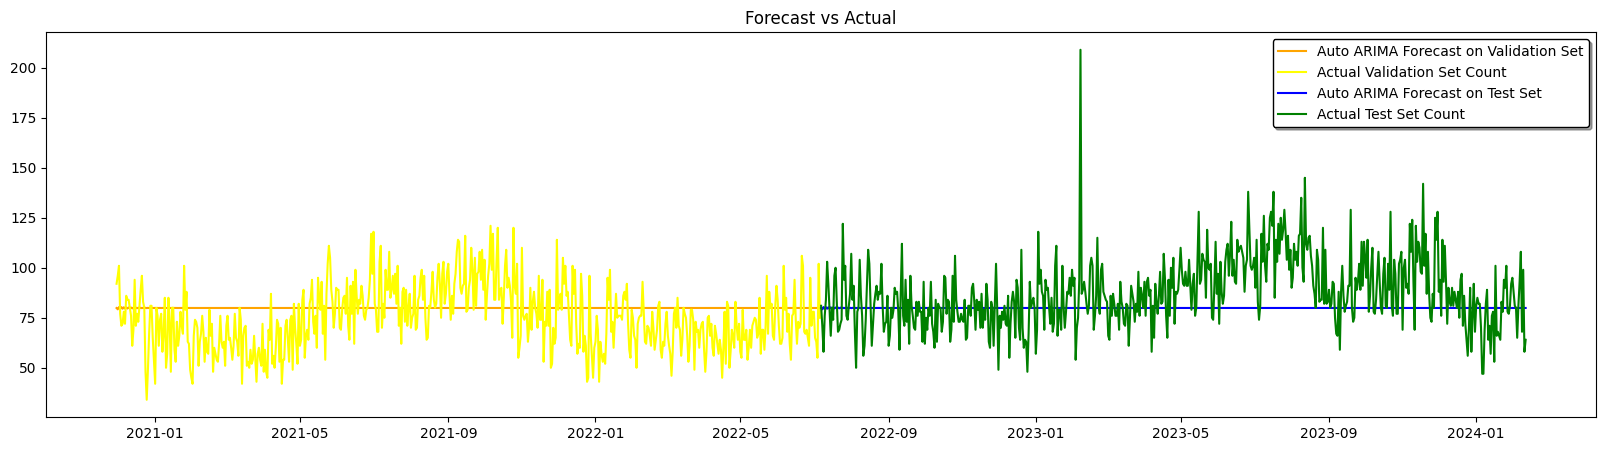

In [155]:
import matplotlib.pyplot as plt

# Forecast using Auto ARIMA model on the validation set
forecast_val_auto_arima = auto_arima_model.predict(n_periods=len(val_data))

# Forecast using Auto ARIMA model on the test set
forecast_test_auto_arima = auto_arima_model.predict(n_periods=len(test_data), return_conf_int=False)

# Plot forecast, validation, and test data
plt.figure(figsize=(20, 5))
plt.title('Forecast vs Actual')
plt.plot(val_data.index, forecast_val_auto_arima, label='Auto ARIMA Forecast on Validation Set', color='orange')
plt.plot(val_data.index, val_data, label='Actual Validation Set Count', color='yellow')
plt.plot(test_data.index, forecast_test_auto_arima, label='Auto ARIMA Forecast on Test Set', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Set Count', color='green')
plt.legend(shadow=True, edgecolor='k')

plt.show()


In [156]:
# # Get the last date in the test data and add one day to it to start the forecast
# start_date = test_data.index[-1] + pd.Timedelta(days=1)

# # Forecast the next 365 days starting from the calculated start date
# forecast_horizon = 365
# forecast = sarima_model_fit.get_forecast(steps=forecast_horizon)

# # Extract forecasted values and confidence intervals
# forecast_values = forecast.predicted_mean
# confidence_intervals = forecast.conf_int()

# # Create a range of dates for the forecast
# forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon, freq='D')

# # Plot the forecasted values and confidence intervals
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Training Data')
# plt.plot(test_data.index, test_data, label='Test Data')
# plt.plot(forecast_dates, forecast_values, color='red', label='Forecast')
# plt.fill_between(forecast_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
# plt.title('Auto ARIMA Forecast for the Next 365 Days')
# plt.xlabel('Date')
# plt.ylabel('Count')
# plt.legend()
# plt.grid(True)


# plt.savefig('AutoARIMA-predict.jpg', format='jpeg', dpi=100)


# plt.show()


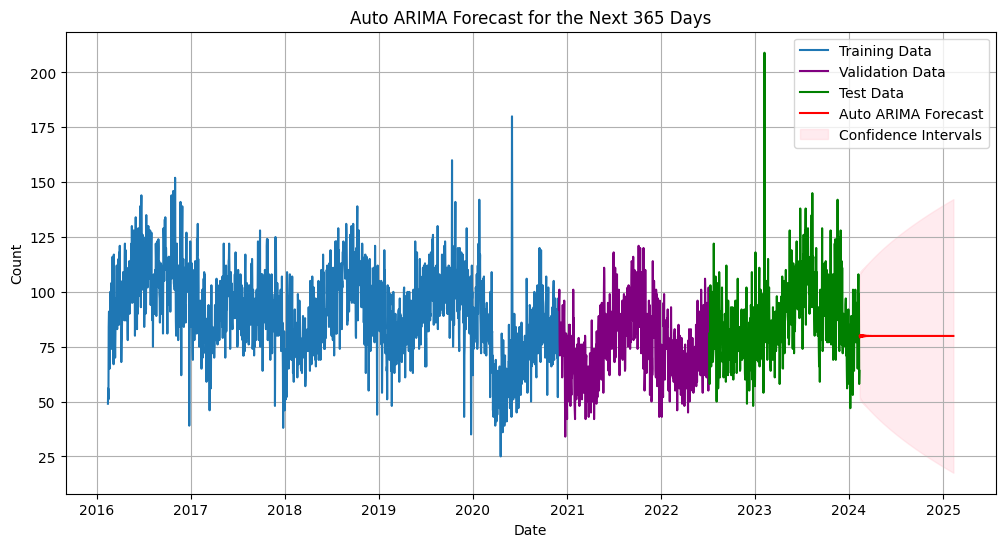

In [158]:
# Import required packages
import matplotlib.pyplot as plt
import pandas as pd

# Define the start date for the forecast
start_date = test_data.index[-1] + pd.Timedelta(days=1)

# Define the forecast horizon (365 days)
forecast_horizon = 365

# Forecast the next 365 days using the Auto ARIMA model
forecast_auto_arima = auto_arima_model.predict(n_periods=forecast_horizon, return_conf_int=True)

# Extract forecasted values and confidence intervals
forecast_values_auto_arima = forecast_auto_arima[0]  # Predicted mean values
confidence_intervals_auto_arima = forecast_auto_arima[1]  # Confidence intervals

# Create a range of dates for the forecast
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon, freq='D')

# Plot the forecasted values, confidence intervals, and actual data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(val_data.index, val_data, label='Validation Data', color='purple')
plt.plot(test_data.index, test_data, label='Test Data',color='green')
plt.plot(forecast_dates, forecast_values_auto_arima, color='red', label='Auto ARIMA Forecast')
plt.fill_between(forecast_dates, confidence_intervals_auto_arima[:, 0], confidence_intervals_auto_arima[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
plt.title('Auto ARIMA Forecast for the Next 365 Days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('AutoARIMA_forecast.jpg', format='jpeg', dpi=100)

# Show the plot
plt.show()
